### REI505M Final project: Music genre classification starter pack

The following Dataset class operates on the GTZAN dataset.

* The duration of most GTZAN files are 30 seconds (3022050=661500 samples) but some are slightly shorter (approx 29.9 seconds). For this reason we truncate at 660000 samples below.
* It may be beneficial to work with smaller chunks than ~30 seconds.
* You may want to perform the data augmentations in the `__get_item__` function.
* For now, `train_dataset` contains all the dataset, you need to set aside some examples for validation and test sets.

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from src.Conv1D import Conv1D
from src.Config import Config
from src.AudioDataset import AudioDataset
from src.DataPreparation import get_partitioned_data
from src.Augmentations import Augmentations
import src.Utils as Utils 

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on:", device)

config = Config(#Path to folder with GTZAN files:
                audio_dir_path='../music/',
                fma_audio_dir_path='../fma_small/',
                # music/
                #  - rock/
                #       rock.00099.wav
                #       ...
                #  - reggie/
                #  ...
                #  - blues/
                #Choose how many genres we want to use:
                num_genres=10, # eg. 2, 3, 5, 10
                duration_size= 29, # länge der wav-files
                sampling_rate = 22050,
                #Data Partition
                train_part_size=0.7,
                val_part_size=0.15,
                test_part_size=0.15,
                batch_size=8, 
                learning_rate=1e-3,
                epochs=50, 
                seed=42,
                device=device)

torch.manual_seed(config.seed) # Reproducible results

Training on: cpu


In [3]:
#Load num_genres from data and partition them
train_files, train_labels, val_files, val_labels, test_files, test_labels = get_partitioned_data(config)

#Setup Augmentations
augmentations = Augmentations(#The augmentations, from which is chosen whenever augment() is called:
                              available_augmentations= ['no_augment', 'no_augment', 'RandomStartCrop', 'FlipWave', 'ReverseWave'], #(names of functions in Augments-class)
                              #available_augmentations= ['no_augment', 'no_augment', 'FlipWave', 'ReverseWave'], #(names of functions in Augments-class)
                              num_augments=3, #Number of total augmentations (including those fixed in always_augment)
                              always_augment=[0, 0, 1, 0, 0],   #Which augmentations to always use (bitmap on available_augmentations)
                              cropt_size = 20,
                              sampling_rate = config.sampling_rate)

#Create Datasets and Dataloaders
train_dataset = AudioDataset(audio_files=train_files, labels=train_labels, audio_path=config.audio_dir_path, 
                             sampling_rate=config.sampling_rate, 
                             duration=config.duration_size, #Duration *before* augmentation.
                             augmentations=augmentations) #Only provide train_dataset with augmentations
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

val_dataset = AudioDataset(val_files, val_labels, config.audio_dir_path,
                           sampling_rate= config.sampling_rate, duration= augmentations.cropt_size)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

test_dataset = AudioDataset(test_files, test_labels, config.audio_dir_path,
                            sampling_rate=config.sampling_rate, duration=augmentations.cropt_size)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)                            

print("Sanity Check Train Loader:")
tmp_features, tmp_labels = next(iter(train_loader))
print(f"Feature batch shape: {tmp_features.size()}")
print("First sample: ", tmp_features[0])
print(f"Labels batch shape: {tmp_labels.size()}")

print("Sanity Check Valdidation Loader:")
tmp_features, tmp_labels = next(iter(val_loader))
print(f"Feature batch shape: {tmp_features.size()}")
print("First sample: ", tmp_features[0])
print(f"Labels batch shape: {tmp_labels.size()}")

print("Sanity Check Test Loader:")
tmp_features, tmp_labels = next(iter(test_loader))
print(f"Feature batch shape: {tmp_features.size()}")
print("First sample: ", tmp_features[0])
print(f"Labels batch shape: {tmp_labels.size()}")

Using 10 genres ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total selected files 1000 | Training set 700 | Validation set 150 | Test set 150
Sanity Check Train Loader:
Feature batch shape: torch.Size([8, 441000])
First sample:  tensor([-669., -230.,  -33.,  ..., 4282., 4457., 4511.])
Labels batch shape: torch.Size([8])
Sanity Check Valdidation Loader:
Feature batch shape: torch.Size([8, 441000])
First sample:  tensor([1436., 2053., 1372.,  ..., -938., -881., -936.])
Labels batch shape: torch.Size([8])
Sanity Check Test Loader:
Feature batch shape: torch.Size([8, 441000])
First sample:  tensor([ 1239.,  2100.,  1110.,  ..., -1530., -1950., -2273.])
Labels batch shape: torch.Size([8])


INPUT SIZE OF HIDDEN DENSE LAYER 640
Epoch 1/50 -  val loss: 1.6786 |  val acc: 0.38 | train loss 1.9982 | train acc 0.2871 | time 62.03s | per batch 656.86ms
Epoch 2/50 -  val loss: 1.7167 |  val acc: 0.41 | train loss 1.8363 | train acc 0.3543 | time 60.53s | per batch 637.26ms
Epoch 3/50 -  val loss: 1.6253 |  val acc: 0.43 | train loss 1.5935 | train acc 0.4429 | time 60.58s | per batch 637.05ms
Epoch 4/50 -  val loss: 1.5736 |  val acc: 0.43 | train loss 1.5170 | train acc 0.4686 | time 61.05s | per batch 645.13ms
Epoch 5/50 -  val loss: 1.4641 |  val acc: 0.49 | train loss 1.4431 | train acc 0.4900 | time 57.23s | per batch 603.24ms
Epoch 6/50 -  val loss: 1.5694 |  val acc: 0.47 | train loss 1.3665 | train acc 0.5100 | time 57.95s | per batch 609.94ms
Epoch 7/50 -  val loss: 1.3733 |  val acc: 0.49 | train loss 1.3023 | train acc 0.5614 | time 58.13s | per batch 612.59ms
Epoch 8/50 -  val loss: 1.3399 |  val acc: 0.47 | train loss 1.2153 | train acc 0.5671 | time 58.54s | per ba

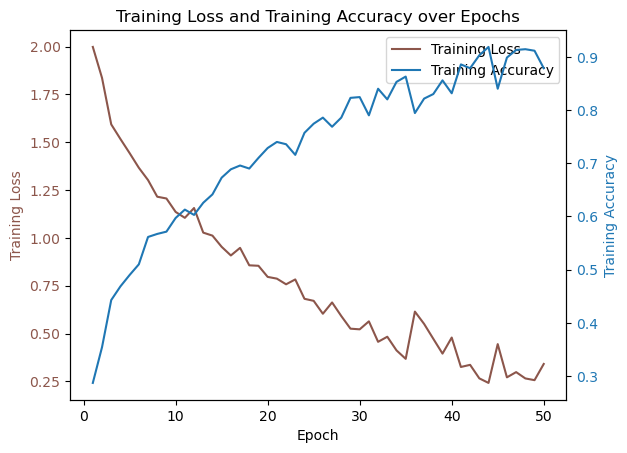

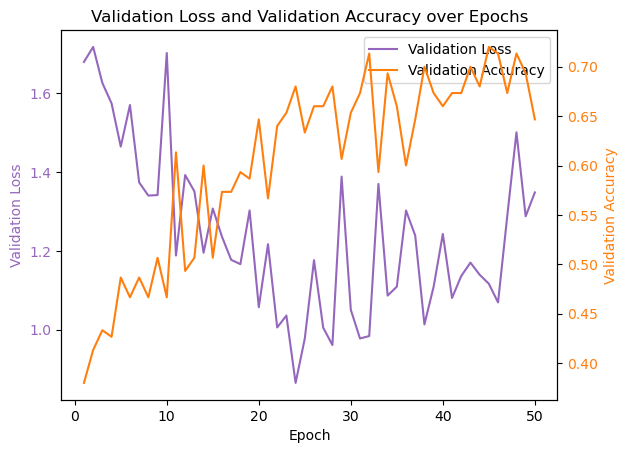

In [4]:
#Train model
n_classes = config.num_genres
model = Conv1D(num_blocks=5,
               num_conv_layers_per_block=1,
               kernel_size=12,
               num_first_layer_kernels=16,
               conv_stride=4,
               pool_stride=5,
               dense_size=100,
               do_batch_norm=True,
               n_classes=n_classes,
               config=config,
               channels=[32, 64, 80, 96, 128],
               kernel_sizes=[24, 12, 8, 6, 4],
               conv_strides=[4, 3, 3, 2, 1],
               pool_strides=[5, 5, 4, 4, 3]
               ).to(config.device)

opt = torch.optim.Adam(model.parameters(), config.learning_rate)
crit = nn.CrossEntropyLoss()

best_val_acc = 0.0
best_model_state = None

Utils.train(train_loader, val_loader, model, opt, lossfunc=crit, config=config, show_batch_time=True)

In [8]:
#Test model
Utils.test(test_loader, model, lossfunc=crit, config=config)

test loss 1.2324 | test acc 0.6600 | time 4.20s | per batch 221.30ms


In [7]:
# Saving
torch.save(model.state_dict(), "../model_fma.pth")

In [108]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from src.FMA import load_fma_small_testset
from src.FMA import FMAAudioDataset


corrupted = ["133297.wav", "098565.wav", "098567.wav", "098569.wav", "099134.wav", "108925.wav"]  # optional
# Load test set
file_paths, labels = load_fma_small_testset(config, corrupted_files=corrupted)

# Create Dataset
dataset = FMAAudioDataset(
    audio_files=file_paths,
    labels=labels,
    audio_path=config.fma_audio_dir_path,
    sampling_rate=config.sampling_rate,
    duration=augmentations.cropt_size
)



# Wrap in DataLoader
fma_loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)

# Test the model
Utils.test(fma_loader, model, lossfunc=crit, config=config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(106574, 52)
After genre filter: (300, 52)
Loaded FMA-small TEST subset:
  Total usable files: 300
  Total usable labels: 300
  Genres included: {'hiphop', 'rock', 'pop'}
test loss 4.4667 | test acc 0.2633 | time 8.85s | per batch 233.00ms


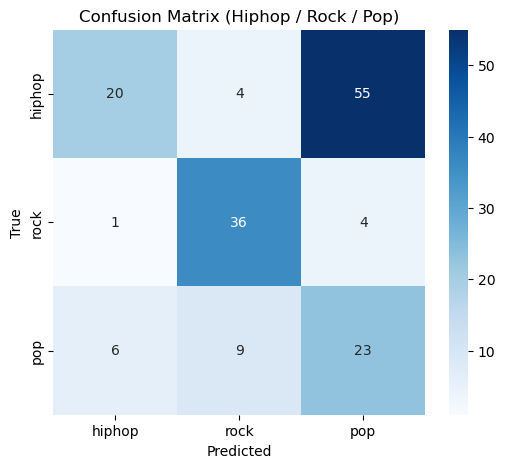

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in fma_loader:
        data = data.to(config.device)
        target = target.to(config.device)

        logits = model(data)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Only keep hiphop(4), rock(9), pop(7)
valid_classes = {4, 9, 7}

mask = np.array([t in valid_classes for t in all_targets])

filtered_targets = all_targets[mask]
filtered_preds   = all_preds[mask]

# Map 4→0 (hiphop), 9→1 (rock), 7→2 (pop)
label_map = {4:0, 9:1, 7:2}
inv_map   = {0:"hiphop", 1:"rock", 2:"pop"}

y_true = np.array([label_map[x] for x in filtered_targets])

# If the model predicts a genre outside 4/7/9, count it as "unknown"
y_pred = np.array([label_map[p] if p in label_map else -1 for p in filtered_preds])

# Remove -1 predictions before computing confusion matrix
valid_pred_mask = y_pred != -1
y_true = y_true[valid_pred_mask]
y_pred = y_pred[valid_pred_mask]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[inv_map[i] for i in range(3)],
            yticklabels=[inv_map[i] for i in range(3)],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Hiphop / Rock / Pop)")
plt.show()


In [ ]:
(20+35+23)/(20+35+23+4+55+1+4+6+9)
# 150 in our three genres, the rest in others (150 )

# evaluate the classifier as: choose the highest probability out of the genres M,R,P and do not allow to to choose from the other seven genres. 

0.4968152866242038